In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as tsa


from pmdarima.arima import auto_arima, ndiffs, nsdiffs, ADFTest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Serie 3: Tasa de Política Monetaria

In [140]:
df = pd.read_csv("../dataset/plazo_fijo_bch/historico2.csv")

df.head()

,Date,Tasa de política monetaria,Tipo de cambio Minorista,Suma de results.valor
0,2016-01-04 00:00:00,"33,00",13.31,NaN
1,2016-01-05 00:00:00,"33,00",13.88,NaN
2,2016-01-06 00:00:00,"32,00",14.04,NaN
3,2016-01-07 00:00:00,"32,00",14.16,NaN
4,2016-01-08 00:00:00,"32,00",14.10,NaN


In [141]:
# Convertir la columna 'date' a datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d 00:00:00')

# Convertir a formato 'yyyy-mm-dd'
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

In [142]:
df.drop(columns=['Tipo de cambio Minorista', 'Suma de results.valor'], inplace=True)
df.head()

,Date,Tasa de política monetaria
0,2016-01-04,"33,00"
1,2016-01-05,"33,00"
2,2016-01-06,"32,00"
3,2016-01-07,"32,00"
4,2016-01-08,"32,00"


In [143]:
df.rename(columns={'Tasa de política monetaria':'Tasa', 'Date':'Fecha'}, inplace=True)

In [144]:
df = df.set_index('Fecha') 
df = df.sort_index()
df.head()

,Tasa
Fecha,
2016-01-04,"33,00"
2016-01-05,"33,00"
2016-01-06,"32,00"
2016-01-07,"32,00"
2016-01-08,"32,00"


In [145]:
df['Tasa'] = df['Tasa'].str.replace(',', '.').astype(float)

In [146]:
df.shape

(2097, 1)

In [147]:
df = df.dropna()

In [148]:
df.shape

(2060, 1)

<h4>Paso 1</h4>

Graficar los datos, identificar patrones y/o comportamientos inusuales. Una aproximacion visual permite identificar varias caracteristicas de las series, si bien no es determinante siempre es necesario saber como son nuestras bases a trabajar

Histograma

In [203]:
hist = px.histogram(df,  title=f"Histograma")
hist.show()

Boxplot

In [207]:
# Convertir el índice en una columna si aún no lo has hecho
df_copy = df.copy()
df_copy['Fecha'] = df.index

# Extraer el año de la columna 'fecha'
df_copy['año'] = df_copy['Fecha'].str[:4]  # Extraer el año de la fecha en formato 'yyyy-mm-dd'

# Crear el boxplot por año
fig = px.box(df_copy, x='año', y='Tasa', title='Boxplot de Cantidad por Año', color='año')

# Mostrar el gráfico
fig.show()

Gráfico de línea

In [208]:
# Crear un gráfico de serie de tiempo
fig = px.line(df, title='Serie de tiempo interactiva')

# Mostrar el gráfico interactivo
fig.show()

In [211]:
import matplotlib.pyplot as plt

def graficar(serie, titulo="", xlabel="Tiempo", ylabel="Tasa"):
    plt.figure(figsize=(12, 3), dpi=100)  # Crear la figura

    # Graficar la serie directamente y agregar una etiqueta
    serie.plot(label='Tasa')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(titulo)
    plt.legend(loc='best')  # 'best' para la mejor ubicación
    plt.grid(True, color='0.6', dashes=(5, 2, 1, 2))
    
    plt.show()  # Mostrar la gráfica

# Uso de la función
# graficar(serie)  # Asegúrate de que 'serie' tenga datos válidos

<Figure size 1200x300 with 0 Axes>

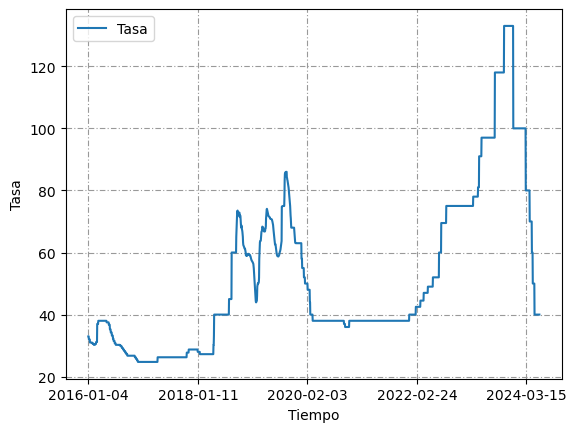

In [212]:
graficar(df)

Descomposicion aditiva

In [209]:
# Esta función descompone la serie en sus partes para ver estacionalidad, tendencia, residuos
def componentes(timeserie):
  decomposition = seasonal_decompose(timeserie, model='additive', period=252)
  fig = plt.figure()
  fig = decomposition.plot()
  fig.set_size_inches(15, 8)

<Figure size 640x480 with 0 Axes>

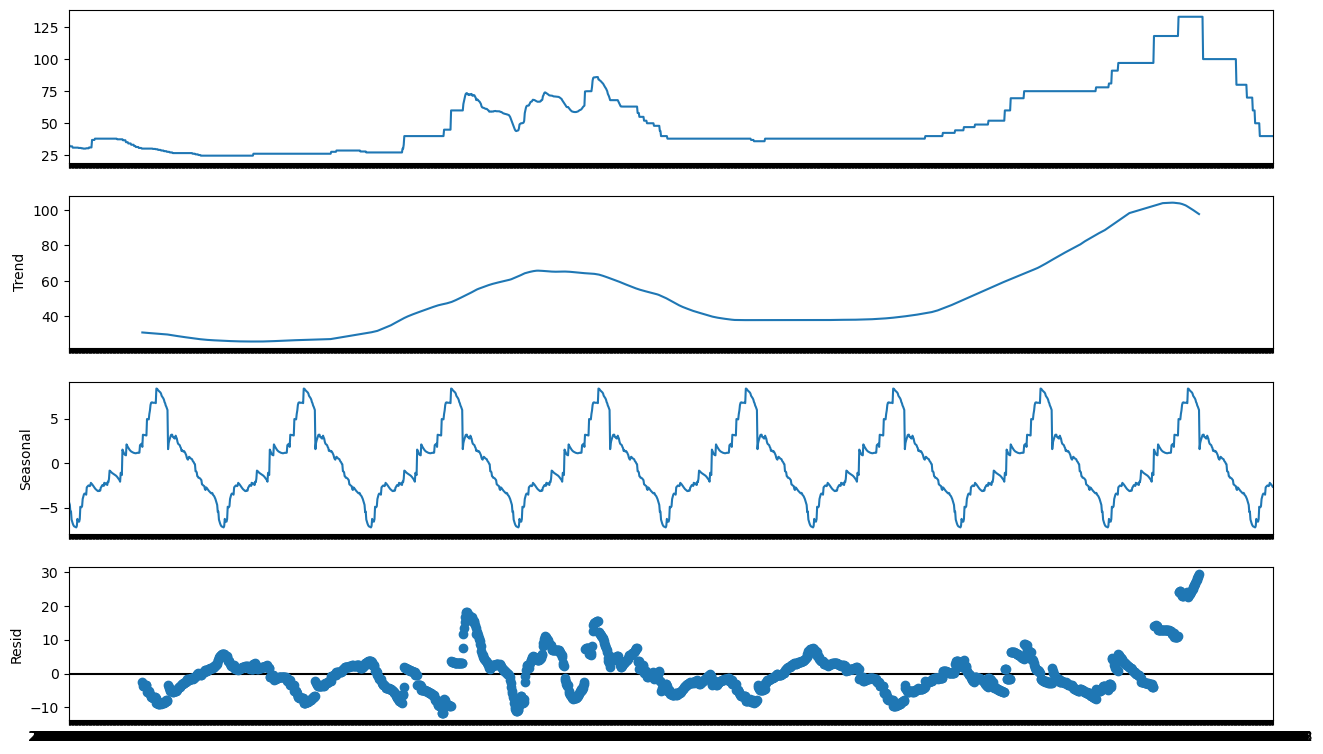

In [210]:
componentes(df)

*Se observa estacionalidad*

ACF y PACF + Autocovarianza

In [154]:
## Función para dibujar juntos FAS: autocovarianzas; FAC y FACP, autocorrelación y autocorrelación parcial
def autocov_autocorr(serie_r, nrol=75):
    fig, axes = plt.subplots(3, 1, figsize=(18, 10))

    plot_acf(serie_r, lags=nrol, ax=axes[0], color='blue', vlines_kwargs={"colors": 'blue'})
    axes[0].set_title('ACF (Autocorrelación)', fontsize=14)

    plot_pacf(serie_r, lags=nrol, ax=axes[1], color='green', vlines_kwargs={"colors": 'green'}, method='ywm')
    axes[1].set_title('PACF (Autocorrelación Parcial)', fontsize=14)

    axes[2].plot(tsa.acovf(serie_r, fft=False, nlag=nrol), color='red', label='AutoCov')
    axes[2].set_title('Autocovarianza', fontsize=14)
    axes[2].set_xlabel('Lag')

    plt.tight_layout()
    plt.show()

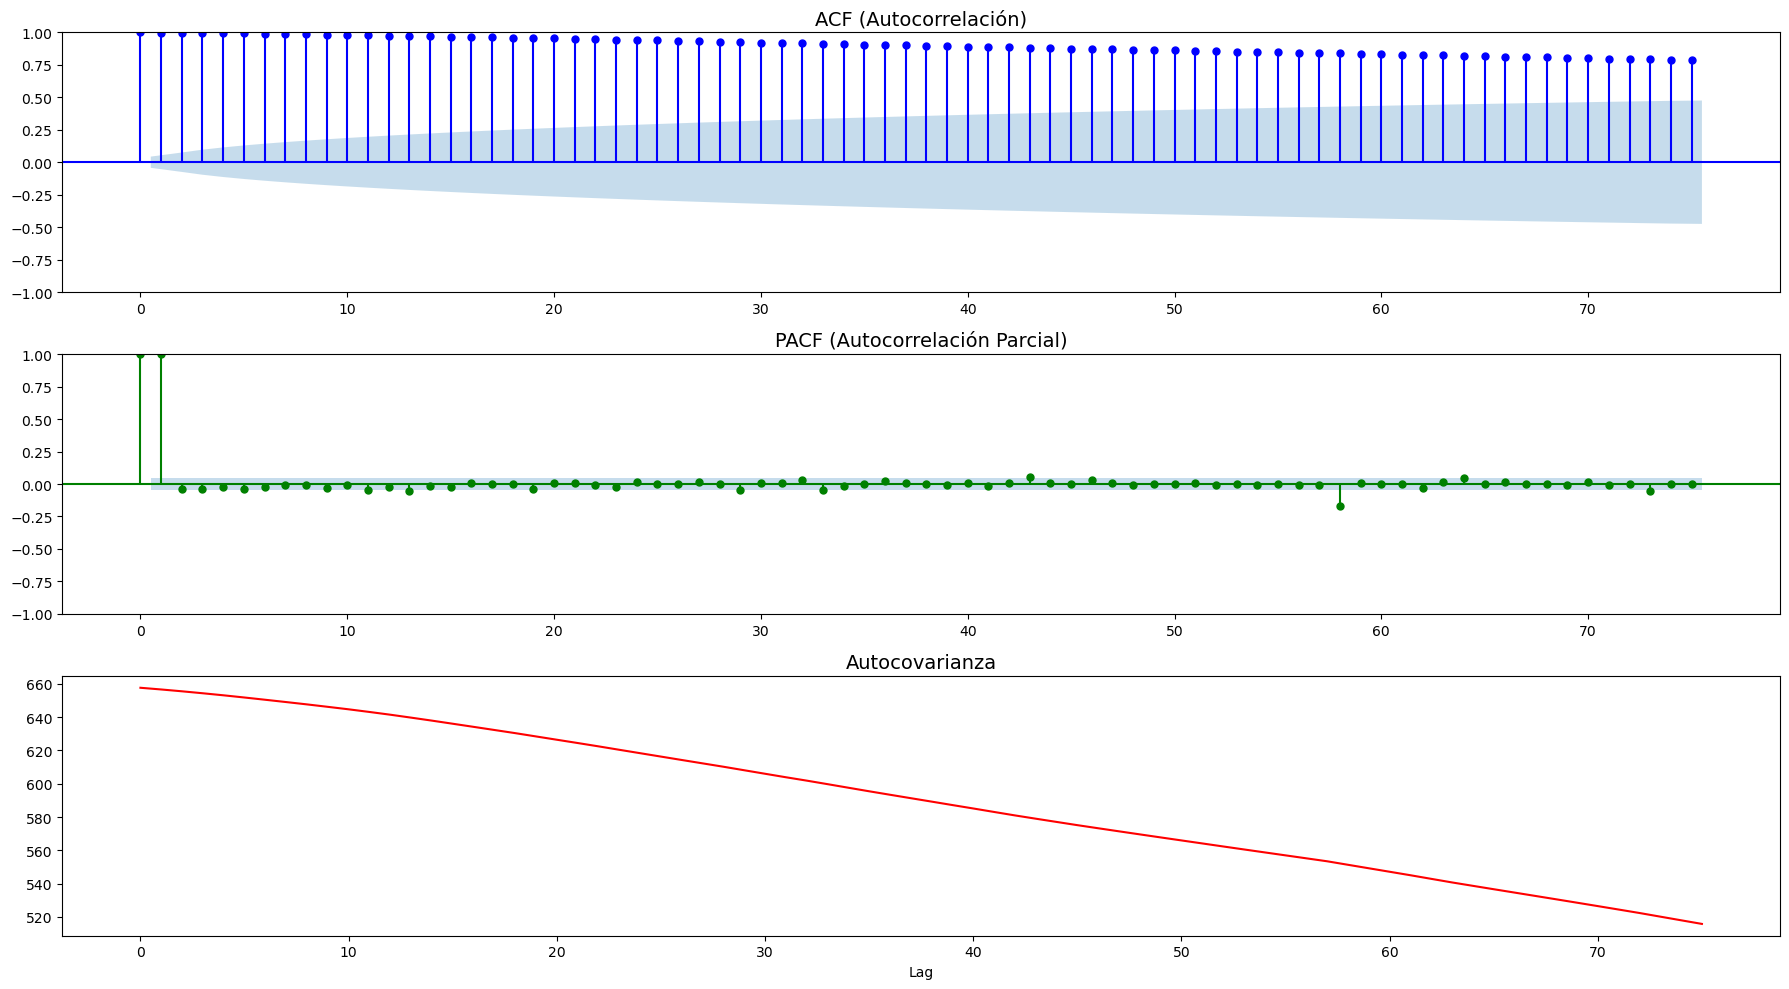

In [155]:
autocov_autocorr(df)

*Si miramos el grafico de autocorrelacion, vemos que se comporta como un AR(1) (Random Walk). Si lo diferenciamos una vez para convertirse en estacionaria.*

<h4>Paso 2</h4>

Si es necesario utilizar transformacion de Box-Cox para estabilizar la varianza. Aquí se propone una transformación de los datos a fin de mejorar la homocedasticidad. Estas transformaciones se usan para estabilizar la varianza y produce que las desviaciones alrededor del modelo sean mas normalmente distribuidas

Codigo en Clase 2 - ejer 2

<h4>Paso 3</h4>
Modelamos: AUTO_ARIMA



Train y test

In [156]:
# Separacion Train/Test  ---> esta es otra variable a analizar
# Seleccionamos el primer 80% para train
train = df.iloc[:round(len(df)*.8)]
# Seleccionamos el 20% restante para test
test = df.iloc[round(len(df)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train.shape, test.shape)

(1648, 1) (412, 1)


*Vemos que en todos hace 1 integracion.*

In [157]:
stepwise_fit = auto_arima(train, trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3828.537, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3897.077, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3856.046, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3863.561, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3896.797, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3825.964, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3848.556, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3825.198, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3825.804, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3839.406, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3823.766, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3862.927, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3855.289, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3824.291, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]          

Modelo ARMA 

In [158]:
modelo1 = sm.tsa.arima.ARIMA(train, order=(1,0,1))
resultado1 = modelo1.fit()
resultado1.summary()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Tasa   No. Observations:                 1648
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1933.786
Date:                Wed, 16 Oct 2024   AIC                           3875.573
Time:                        14:15:55   BIC                           3897.202
Sample:                             0   HQIC                          3883.592
                               - 1648                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.9238     94.486      0.444      0.657    -143.265     227.112
ar.L1          0.9996      0.001    805.423      0.000       0.997       1.002
ma.L1          0.1348      0.013     10.408      0.000       0.109       0.160
sigma2         0.6093      0.004    155.737      0.000       0.602       0.617
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):           1323539.28
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               4.10   Skew:                             9.01
Prob(H) (two-sided):                  0.00   Kurtosis:                       140.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Modelo ARIMA recomendado

In [159]:
modelo1 = sm.tsa.arima.ARIMA(train, order=(1,1,1))
resultado1 = modelo1.fit()
resultado1.summary()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Tasa   No. Observations:                 1648
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1908.883
Date:                Wed, 16 Oct 2024   AIC                           3823.766
Time:                        14:15:57   BIC                           3839.986
Sample:                             0   HQIC                          3829.781
                               - 1648                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8474      0.050     16.876      0.000       0.749       0.946
ma.L1         -0.7313      0.057    -12.757      0.000      -0.844      -0.619
sigma2         0.5945      0.003    198.081      0.000       0.589       0.600
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):           1407290.99
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               4.19   Skew:                             9.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       145.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Test de Dickey Fuller

In [160]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
  print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
  dftest = adfuller(series, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  if dftest[1] <= 0.05:
    print("Conclusion:====>")
    print("Rechazar la hipótesis nula")
    print("Los datos son estacionarios.")
  else:
    print("Conclusion:====>")
    print("No rechazar la hipótesis nula")
    print("Los datos no son estacionarios.")

In [161]:
Augmented_Dickey_Fuller_Test_func(train,'Tasa')

Resultados de la prueba de Dickey-Fuller para columna: Tasa
Test Statistic                   -1.619052
p-value                           0.473226
No Lags Used                     12.000000
Number of Observations Used    1635.000000
Critical Value (1%)              -3.434356
Critical Value (5%)              -2.863309
Critical Value (10%)             -2.567712
dtype: float64
Conclusion:====>
No rechazar la hipótesis nula
Los datos no son estacionarios.


In [162]:
def print_test_afd(y):
  resultado = tsa.adfuller(y)
  print('Estadistico ADF: %f' % resultado[0])
  print('p-valor: %f' % resultado[1])
  print('Valores criticos:')
  for key, valor in resultado[4].items():
    print('\t%s: %.3f' % (key, valor))

In [163]:
def test_stationarity(timeseries):

    #Rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

Analisis de estacionariedad de las series de residentes

In [164]:
print_test_afd(train)

Estadistico ADF: -1.619052
p-valor: 0.473226
Valores criticos:
	1%: -3.434
	5%: -2.863
	10%: -2.568


*Como el pvalor es mayor a 0.05 entonces la serie es NO ESTACIONARIA.*

Componentes deterministicos - Test de Raíces Unitarias - Dickey Fuller

In [167]:
# ADF para la serie con "none" regression: # No incluye término independiente ni lineal (“None”)
adf_none_df = adfuller(df, maxlag=None, regression='n', autolag='AIC', store=False, regresults=False)
print("\nADF Test Results for df (None regression):")
print('Estadistico ADF: %f' % adf_none_df[0])
print('p-valor: %f' % adf_none_df[1])
print('Valores criticos:')
for key, valor in adf_none_df[4].items():
    print('\t%s: %.3f' % (key, valor))

# ADF test con Drift: # Incluya término independiente pero no incluye término lineal (“Drift”)
adf_drift_df = adfuller(df, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
print("\nADF Test Results for df (Drift regression):")
print('Estadistico ADF: %f' % adf_drift_df[0])
print('p-valor: %f' % adf_drift_df[1])
print('Valores criticos:')
for key, valor in adf_drift_df[4].items():
    print('\t%s: %.3f' % (key, valor))

# ADF test con Trend: # Incluya ambos términos (“Trend”) - se denomina Ecuación de Dickey Fuller Aumentada
adf_trend_df = adfuller(df, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)
print("\nADF Test Results for df (Trend regression):")
print('Estadistico ADF: %f' % adf_trend_df[0])
print('p-valor: %f' % adf_trend_df[1])
print('Valores criticos:')
for key, valor in adf_trend_df[4].items():
    print('\t%s: %.3f' % (key, valor))



ADF Test Results for df (None regression):
Estadistico ADF: -0.679502
p-valor: 0.421244
Valores criticos:
	1%: -2.567
	5%: -1.941
	10%: -1.617

ADF Test Results for df (Drift regression):
Estadistico ADF: -1.752181
p-valor: 0.404447
Valores criticos:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test Results for df (Trend regression):
Estadistico ADF: -1.787825
p-valor: 0.710599
Valores criticos:
	1%: -3.963
	5%: -3.413
	10%: -3.128


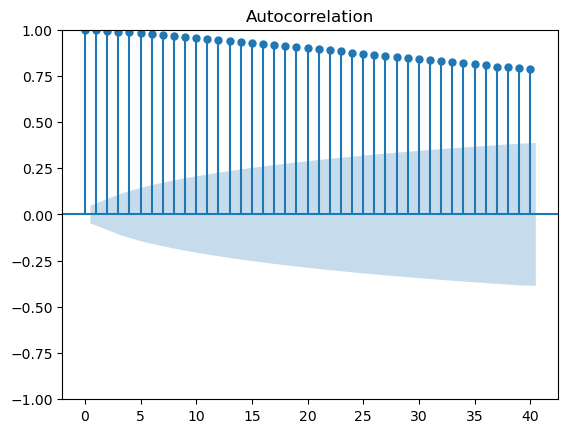

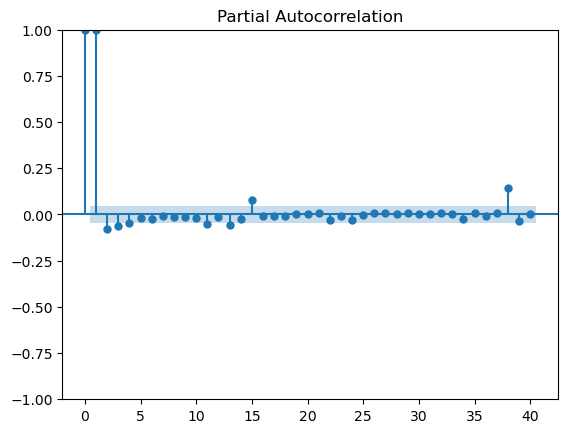

In [48]:
plot_acf(train,lags=40);
plot_pacf(train,lags=40);

A continuacion, analizamos mediante diferentes pruebas el orden de diferenciacion requerido para que la serie pueda llegar a ser estacionaria. Este es un analizis complementario, junto con los otros realizados. <br>
Las pruebas realizadas son:
<ol>
  <li>Prueba de Dickey-Fuller aumentada</li>
  <li>Prueba de Kwiatkowski-Phillips-Schmidt-Shin</li>
  <li>Prueba de Phillips-Perron</li>
</ol>

In [168]:
def estacionario(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = ADFTest(alpha=0.05)
  print(adftest.should_diff(y))

In [169]:
estacionario(train)

Estimado de número de diferencias con ADF test
1
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
1
Se debe realizar diferenciación (should_diff) ADF Test
(0.688676434822501, True)


*Todos los tests coinciden en que debo diferenciar una vez la serie*

Realizamos una primera diferencia de la serie original

In [170]:
serie_tasas_cut_diff_1 = train - train.shift(1)
serie_tasas_cut_diff_1= serie_tasas_cut_diff_1.dropna()

# Separacion Train/Test
# Seleccionamos el primer 80% para train
train_diff_1 = serie_tasas_cut_diff_1.iloc[:round(len(serie_tasas_cut_diff_1)*.8)]
# Seleccionamos el 20% restante para test
test_diff_1 = serie_tasas_cut_diff_1.iloc[round(len(serie_tasas_cut_diff_1)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado

<Figure size 1200x300 with 0 Axes>

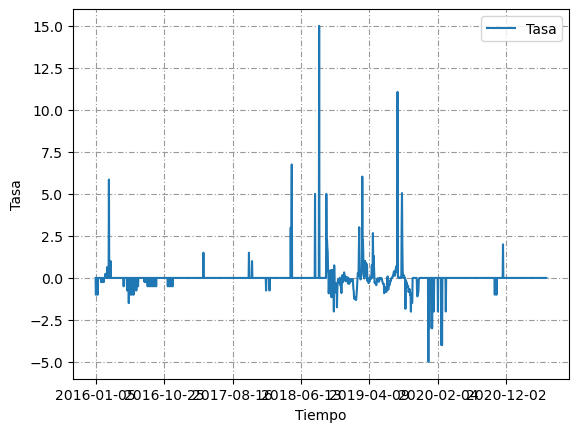

In [171]:
graficar(train_diff_1)

In [172]:
print_test_afd(train_diff_1)

Estadistico ADF: -7.246816
p-valor: 0.000000
Valores criticos:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [56]:
# No incluye término independiente ni lineal (“None”)
tsa.adfuller(train_diff_1, maxlag=None, regression='n', autolag='AIC', store=False, regresults=False)

(-7.248528177506635,
 1.6733181087123723e-11,
 14,
 1303,
 {'1%': -2.5674580226986663,
  '5%': -1.94120810753012,
  '10%': -1.616617749766995},
 2958.737257083115)

In [57]:
# Incluya término independiente pero no incluye término lineal (“Drift”)
tsa.adfuller(train_diff_1, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-7.246815953439092,
 1.823142901474294e-10,
 14,
 1303,
 {'1%': -3.435378572037035,
  '5%': -2.863760700696655,
  '10%': -2.56795231450063},
 2960.7188250982526)

In [58]:
# Incluya ambos términos (“Trend”) - se denomina Ecuación de Dickey Fuller Aumentada
tsa.adfuller(train_diff_1, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

(-7.255732398335781,
 3.702288808017746e-09,
 14,
 1303,
 {'1%': -3.965734694060732,
  '5%': -3.4138647977674266,
  '10%': -3.129036665741405},
 2962.533320562285)

In [59]:
estacionario(train_diff_1)

Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)


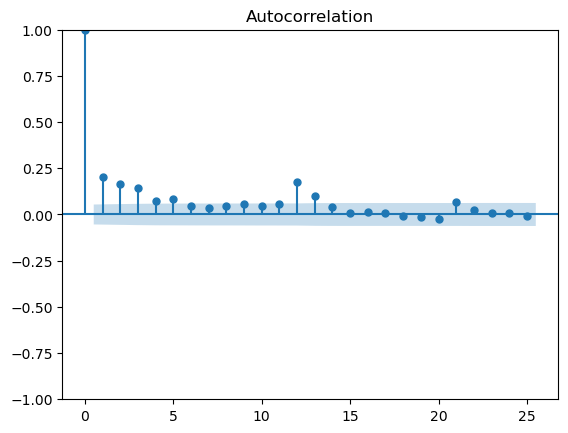

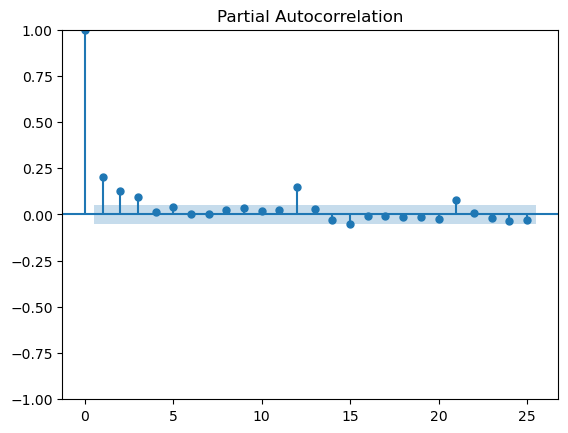

In [60]:
plot_acf(train_diff_1,lags=25);
plot_pacf(train_diff_1,lags=25);

*Vemos una caida exponencial en el ACF por lo que indica estacionariedad. También lo confirmamos con el test de Dickey Fuller.*

In [100]:
# Funcion para graficar las predicciones.
# Toma como parametros:
# serie_test: la porcion de la serie con los datos de test
# serie_pred: las predicciones hechas por el modelo
# conf_int: el intervalo de confianza de las predicciones

def graficar_pred(serie_test, serie_pred, conf_int, titulo="Valores Originales vs Predicciones", xlabel="Año", ylabel="Pasajeros"):
    plt.figure(figsize=(12,3), dpi=100)
    

    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.plot(label="Predicciones")

    # Pasamos dataframe con los intervalos de confianza a series de Pandas y graficamos
    conf_int.iloc[:,1].plot(label="Intervalo de Confianza Superior")
    conf_int.iloc[:,0].plot(label="Intervalo de Confianza Inferior")

    #plt.set_xlabel(xlabel)
    #plt.set_ylabel(ylabel)
    #plt.set_title(titulo)
    plt.legend(loc=0)
    plt.grid(True, color='0.6', dashes=(5,2,1,2))
    plt.show()

In [63]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

<h4>Modelo ARMA</h4>

In [64]:
# Aqui hacemos el loop probando diferentes "p" y "q", para saber cual es el criterio de informacion mas bajo.

import itertools
import statsmodels.api as sm

p_values = range(0, 3)
q_values = range(0, 3)


resultados = []
mejor_aic = float("inf")
mejor_order = None
mejor_modelo = None


for p, q in itertools.product(p_values, q_values):
    try:

        modelo = sm.tsa.arima.ARIMA(train_diff_1, order=(p, 0, q))
        resultado = modelo.fit()

        aic = resultado.aic
        resultados.append((p, q, aic))

        if aic < mejor_aic:
            mejor_aic = aic
            mejor_order = (p, q)
            mejor_modelo = resultado

    except Exception as e:
        print(f"Error en el modelo ARMA({p},{q}): {e}")

print(f"Mejor modelo ARMA: order={mejor_order} con AIC={mejor_aic}")

for p, q, aic in resultados:
    print(f"ARMA({p},{q}) AIC: {aic}")


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

Mejor modelo ARMA: order=(1, 1) con AIC=3012.4703132961945
ARMA(0,0) AIC: 3099.7054928225825
ARMA(0,1) AIC: 3056.7444863783694
ARMA(0,2) AIC: 3038.4777849024003
ARMA(1,0) AIC: 3045.1285145407983
ARMA(1,1) AIC: 3012.4703132961945
ARMA(1,2) AIC: 3014.4030449003267
ARMA(2,0) AIC: 3025.1847904683677
ARMA(2,1) AIC: 3014.386982991927
ARMA(2,2) AIC: 3016.0459027413326


In [107]:
##### borrame cuadrito
modeloARMA = sm.tsa.arima.ARIMA(train, order=(1,0,1))
resultadoARMA = modeloARMA.fit()

resultadoARMA.summary()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Tasa   No. Observations:                 1648
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1933.786
Date:                Wed, 16 Oct 2024   AIC                           3875.573
Time:                        12:18:09   BIC                           3897.202
Sample:                             0   HQIC                          3883.592
                               - 1648                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.9238     94.486      0.444      0.657    -143.265     227.112
ar.L1          0.9996      0.001    805.423      0.000       0.997       1.002
ma.L1          0.1348      0.013     10.408      0.000       0.109       0.160
sigma2         0.6093      0.004    155.737      0.000       0.602       0.617
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):           1323539.28
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               4.10   Skew:                             9.01
Prob(H) (two-sided):                  0.00   Kurtosis:                       140.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [173]:
from statsmodels.tsa.arima_model import ARMA

import statsmodels.api as sm
modeloARMA = sm.tsa.arima.ARIMA(train_diff_1, order=(1,0,1))
resultadoARMA = modeloARMA.fit()

resultadoARMA.summary()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Tasa   No. Observations:                 1318
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1502.235
Date:                Wed, 16 Oct 2024   AIC                           3012.470
Time:                        14:18:48   BIC                           3033.206
Sample:                             0   HQIC                          3020.245
                               - 1318                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.058      0.057      0.954      -0.111       0.118
ar.L1          0.8006      0.052     15.410      0.000       0.699       0.902
ma.L1         -0.6404      0.059    -10.943      0.000      -0.755      -0.526
sigma2         0.5721      0.004    150.163      0.000       0.565       0.580
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1472836.64
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               5.13   Skew:                             9.42
Prob(H) (two-sided):                  0.00   Kurtosis:                       165.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<h4>Paso 6</h4>

Analizamos los residuos del modelo

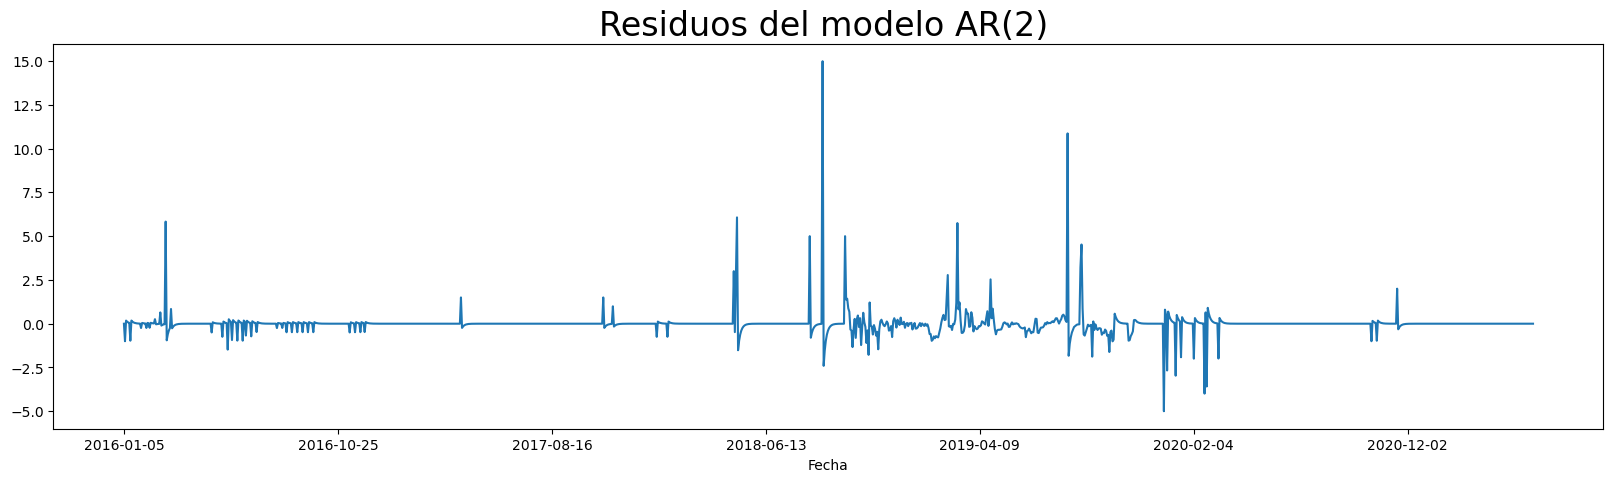

In [174]:
resultadoARMA.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo AR(2) ",size=24)
plt.show()

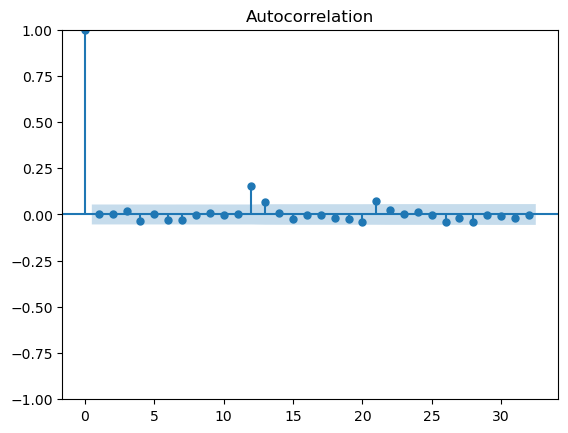

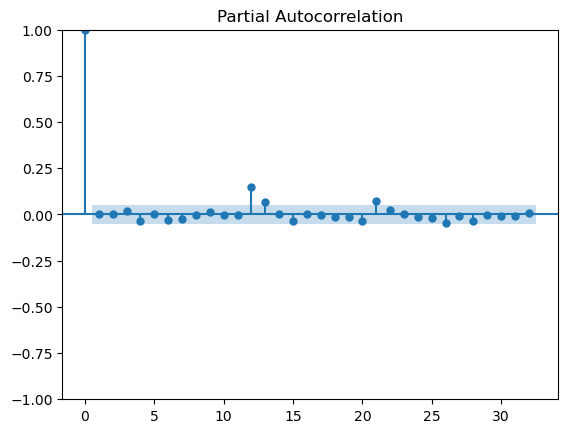

In [175]:
plot_acf(resultadoARMA.resid);
plot_pacf(resultadoARMA.resid);

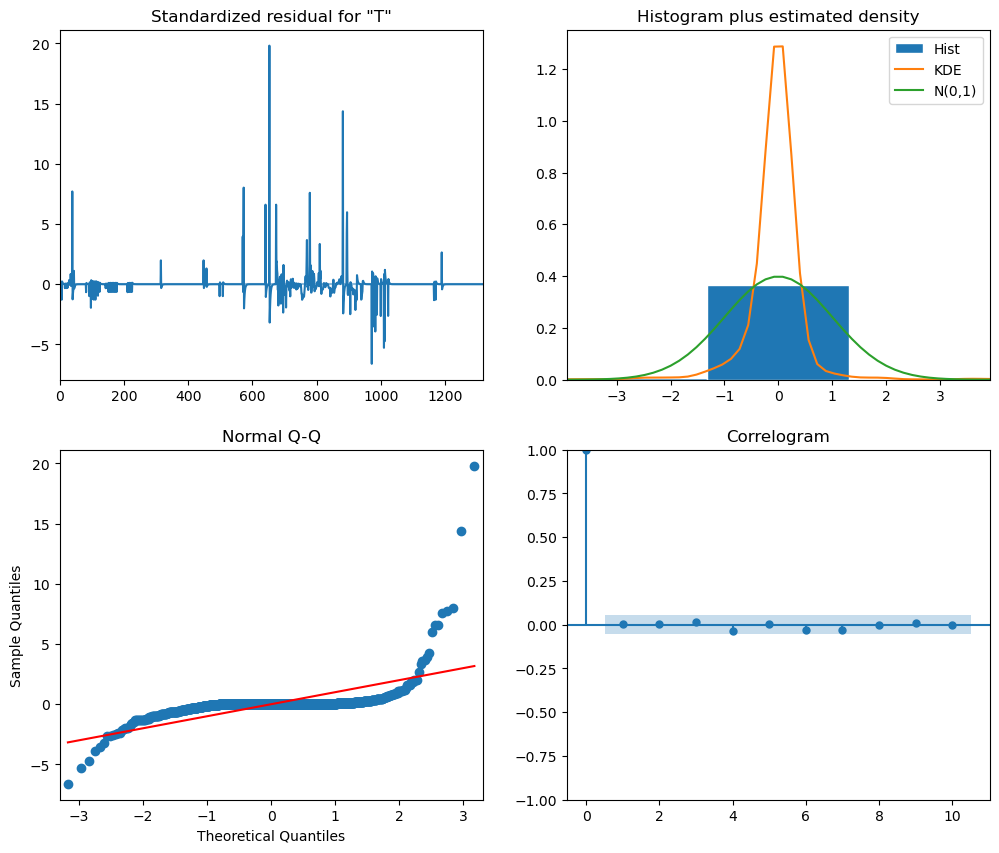

In [79]:
# Diagnostico grafico los residuos del modelo
fig_res_2 = resultadoARMA.plot_diagnostics(figsize=(12,10))

In [71]:
Incorr_residuos_modelo=sm.stats.acorr_ljungbox(resultadoARMA.resid, lags=30)
Incorr_residuos_modelo

,lb_stat,lb_pvalue
1,0.008541,0.926366
2,0.026341,0.986916
3,0.458401,0.927931
4,1.949864,0.744980
5,1.954606,0.855390
6,2.982183,0.811080
7,4.057142,0.773173
8,4.080663,0.849773
9,4.228719,0.895724
10,4.239429,0.935900


Text(0, 0.5, 'P-valores ')

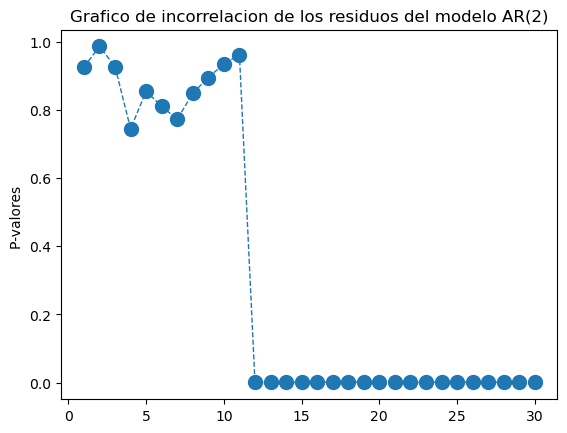

In [72]:
plt.plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo AR(2)")
plt.ylabel("P-valores ")

*Vemos que muchos p-valores están por debajo del 0.05 entonces hay correlación entre residuos.*

Test de Box-Pierce

In [74]:
from statsmodels.tsa.stattools import acf

# Test Box-Pierce
lags = 10

acf_values = acf(resultadoARMA.resid, nlags=lags, fft=False)

In [75]:
from scipy.stats import chi2

# Calculamos el estadistico de prueba Q de Box-Pierce
n = len(resultadoARMA.resid)
Q = n * np.sum(np.square(acf_values[1:lags+1]))
p_value = 1 - chi2.cdf(Q, df=lags)

In [76]:
print(f'Estadística de prueba (Q): {Q:.4f}')
print(f'Valor p: {p_value:.4f}')
alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula: hay autocorrelación significativa en los residuos.")
else:
    print("No se rechaza la hipótesis nula: no hay autocorrelación significativa en los residuos.")

Estadística de prueba (Q): 4.2158
Valor p: 0.9371
No se rechaza la hipótesis nula: no hay autocorrelación significativa en los residuos.


<h4>Paso 7. </h4>

¿ los residuos se comportan como ruido blanco ? Si es afirmativo ---> Prediccion

Modelo ARMA (1,1)

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


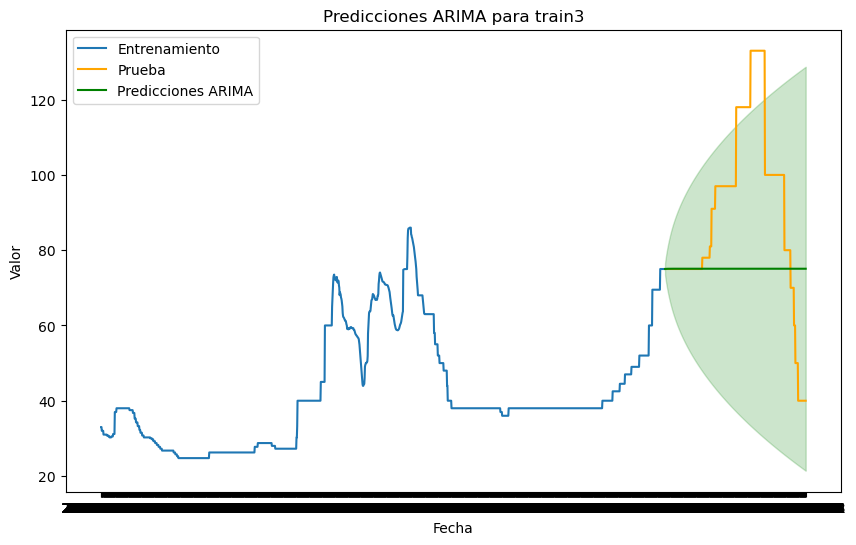

In [193]:
predicciones_arma = resultado1.get_forecast(steps=len(test))
pred_train3 = predicciones_arma.predicted_mean
conf_int = predicciones_arma.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba', color='orange')
plt.plot(test.index, pred_train3, label='Predicciones ARIMA', color='green')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title('Predicciones ARIMA para train3')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

Modelo ARIMA (1,1,1)

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


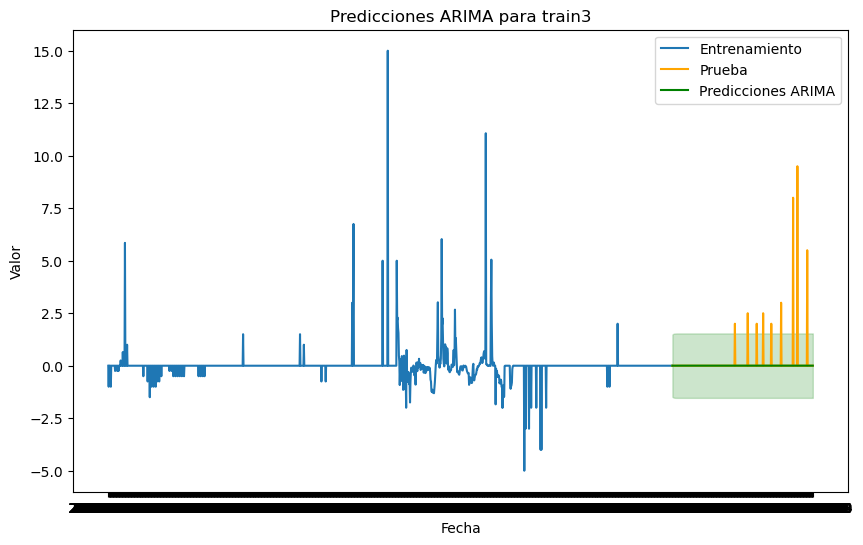

In [192]:
prediccionesARIMA = resultadoARMA.get_forecast(steps=len(test_diff_1))
pred_train3 = prediccionesARIMA.predicted_mean
conf_int = prediccionesARIMA.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(train_diff_1.index, train_diff_1, label='Entrenamiento')
plt.plot(test_diff_1.index, test_diff_1, label='Prueba', color='orange')
plt.plot(test_diff_1.index, pred_train3, label='Predicciones ARIMA', color='green')
plt.fill_between(test_diff_1.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title('Predicciones ARIMA para train3')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

Métricas modelo ARMA

In [194]:
evaluar_metricas(test, predicciones_arma.predicted_mean)

MSE: 779.5383760403371
MAE: 20.578040382753027
RMSE: 27.920214469812674
MAPE: nan


Métricas modelo ARIMA

In [195]:
evaluar_metricas(test_diff_1, prediccionesARIMA.predicted_mean)

MSE: 0.6618700983133615
MAE: 0.11561232252325003
RMSE: 0.8135539922545777
MAPE: nan


<h4>Modelo Sarima</h4>

In [200]:
# SARIMAX Model
sxmodel = auto_arima(train,
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3868.737, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3897.077, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3832.999, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3838.647, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3896.797, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3856.046, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3834.483, Time=0.88 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3834.648, Time=0.56 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3832.672, Time=0.25 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3834.637, Time=1.01 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=5.02 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=3819.872, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3839.406, Time=0.09 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3821.808, Time=0.75 sec
 ARIMA(2,1,0)(0,0,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1648
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -1898.671
Date:                            Wed, 16 Oct 2024   AIC                           3805.342
Time:                                    14:39:57   BIC                           3826.969
Sample:                                         0   HQIC                          3813.361
                                           - 1648                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8013      0.064     12.562      0.000       0.676       0.926
ma.L1         -0.6789      0.072     -9.491      0.000      -0.819      -0.539
ma.S.L12       0.1121      0.010     11.545      0.000       0.093       0.131
sigma2         0.5872      0.004    155.725      0.000       0.580       0.595
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1243559.33
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               4.17   Skew:                             8.92
Prob(H) (two-sided):                  0.00   Kurtosis:                       136.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

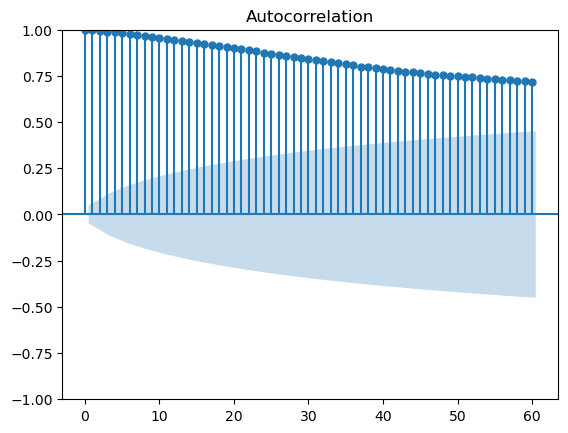

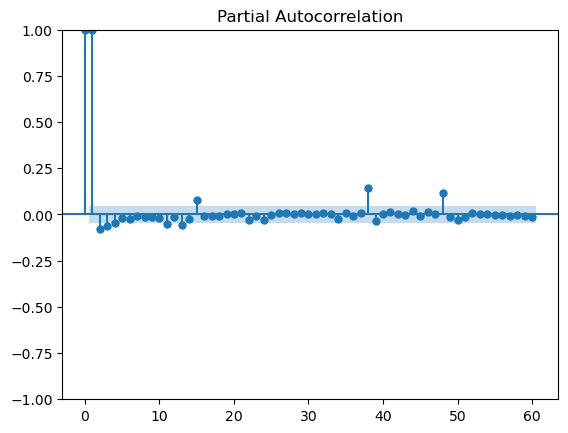

In [112]:
plot_acf(train,lags=60);
plot_pacf(train,lags=60);

In [199]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# (2,1,2)(0,0,1)[12]   
modeloSARIMA2 = SARIMAX(train, order=(2,1,2), seasonal_order=(0,0,1,12))
modeloSARIMA2_fit = modeloSARIMA2.fit()
print(modeloSARIMA2_fit.summary())

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                 Tasa   No. Observations:                 1648
Model:             SARIMAX(2, 1, 2)x(0, 0, [1], 12)   Log Likelihood               -1898.417
Date:                              Wed, 16 Oct 2024   AIC                           3808.834
Time:                                      14:38:28   BIC                           3841.274
Sample:                                           0   HQIC                          3820.862
                                             - 1648                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1571      0.803      0.196      0.845      -1.417       1.731
ar.L2          0.54

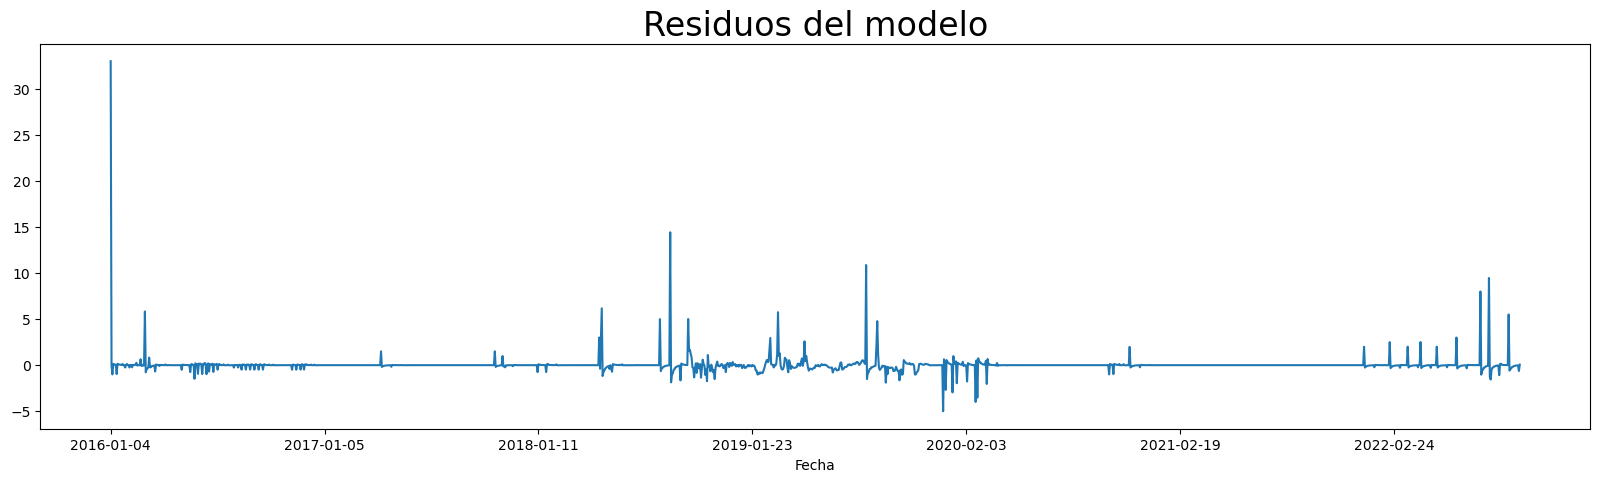

In [114]:
modeloSARIMA2_fit.resid.plot(figsize=(20,5))
plt.title("Residuos del modelo",size=24)
plt.show()

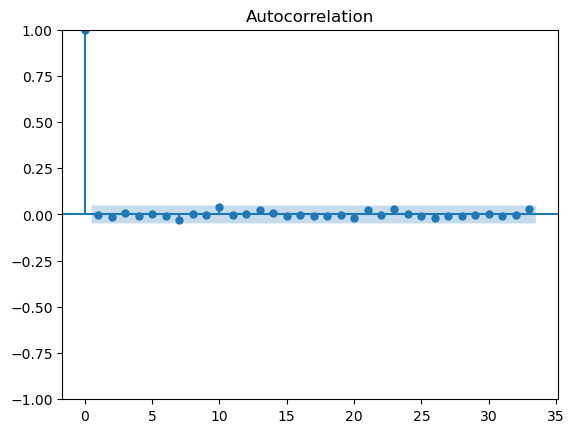

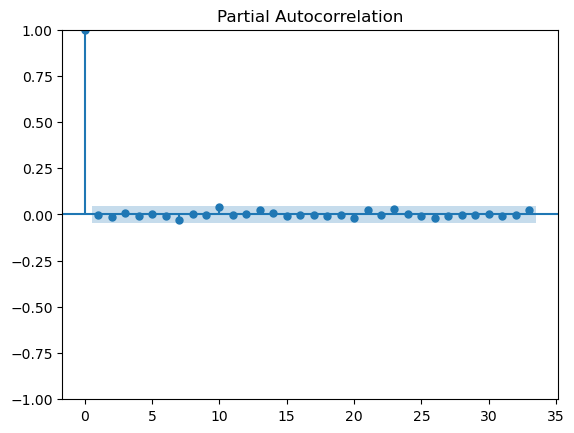

In [115]:
plot_acf(modeloSARIMA2_fit.resid);
plot_pacf(modeloSARIMA2_fit.resid);

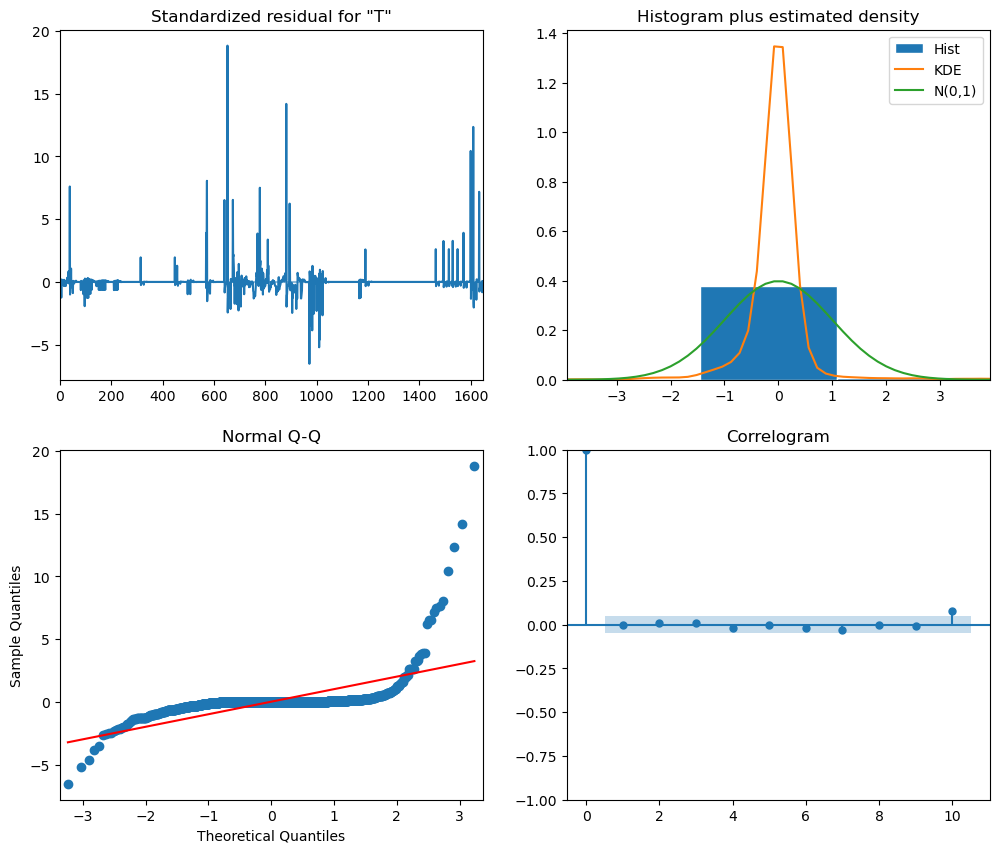

In [116]:
# Diagnostico grafico los residuos del modelo
fig_res_2 = modeloSARIMA2_fit.plot_diagnostics(figsize=(12,10))

Text(0, 0.5, 'P-valores ')

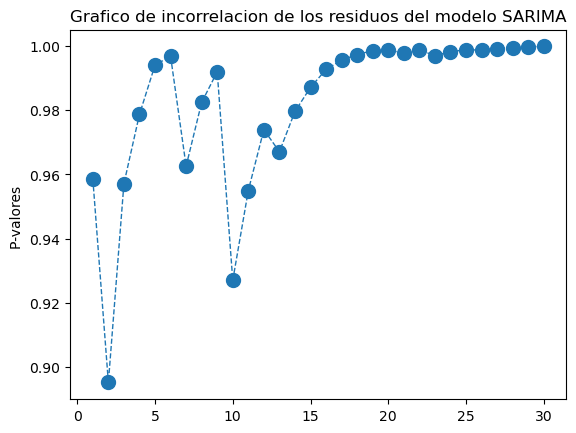

In [117]:
Incorr_residuos_modelo_SARIMA2=sm.stats.acorr_ljungbox(modeloSARIMA2_fit.resid, lags=30)
plt.plot(Incorr_residuos_modelo_SARIMA2.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo SARIMA")
plt.ylabel("P-valores ")

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


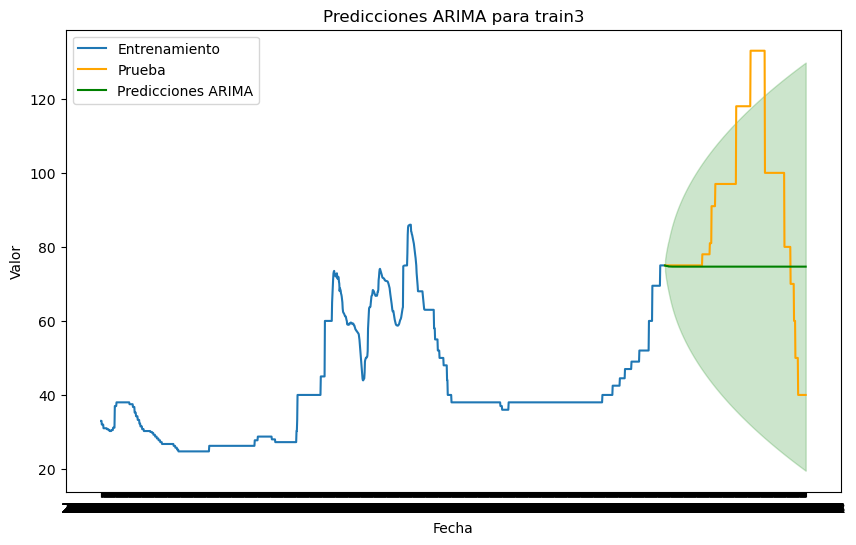

In [201]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
prediccionesSARIMA = modeloSARIMA2_fit.get_forecast(steps=len(test))
pred_train3 = prediccionesSARIMA.predicted_mean
conf_int = prediccionesSARIMA.conf_int()

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba', color='orange')
plt.plot(test.index, pred_train3, label='Predicciones ARIMA', color='green')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title('Predicciones ARIMA para train3')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [202]:
evaluar_metricas(test, prediccionesSARIMA.predicted_mean)

MSE: 791.9991658954624
MAE: 20.853676295033086
RMSE: 28.142479739629596
MAPE: nan


<h4>SARIMAX</h4>

El modelo SARIMAX incorpora variables exógenas para mejorar el pronóstico de series temporales. Combina componentes autorregresivos, de media móvil y estacionales, junto con la influencia de factores externos.

Acá podemos correlacionar con la variable "tipo de cambio minorista" que esta en el dataset.

In [122]:
df_aux = pd.read_csv("../dataset/plazo_fijo_bch/historico2.csv", sep=',')

# Convertir la columna 'date' a datetime
df_aux['Date'] = pd.to_datetime(df_aux['Date'], format='%Y-%m-%d 00:00:00')

# Convertir a formato 'yyyy-mm-dd'
df_aux['Date'] = df_aux['Date'].dt.strftime('%Y-%m-%d')

df_aux.drop(columns=['Suma de results.valor'], inplace=True)

df_aux.rename(columns={'Tasa de política monetaria':'Tasa', 'Date':'Fecha', 'Tipo de cambio Minorista': 'Tipo_Cambio'}, inplace=True)

df_aux['Tasa'] = df_aux['Tasa'].str.replace(',', '.').astype(float)

df_aux = df_aux.dropna()

df_aux = df_aux.set_index('Fecha') 
df_aux = df_aux.sort_index()


df_aux.head()

,Tasa,Tipo_Cambio
Fecha,,
2016-01-04,33.0,13.31
2016-01-05,33.0,13.88
2016-01-06,32.0,14.04
2016-01-07,32.0,14.16
2016-01-08,32.0,14.10


In [123]:
# Separacion Train/Test  ---> esta es otra variable a analizar
# Seleccionamos el primer 80% para train
train_aux = df_aux.iloc[:round(len(df_aux)*.8)]
# Seleccionamos el 20% restante para test
test_aux = df_aux.iloc[round(len(df_aux)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train.shape, test.shape)

(1648, 1) (412, 1)


In [ ]:
df

Vemos relación cruzada

In [127]:
from statsmodels.tsa.stattools import ccf

MediaDestino2_array = train_aux['Tasa'].values
MediaDestino1_array = train_aux['Tipo_Cambio'].values

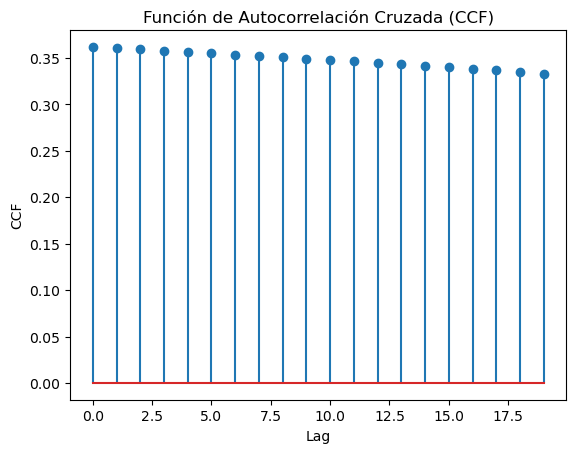

In [129]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# Calculo de CCF
lags = 20
cross_corr = ccf(MediaDestino2_array, MediaDestino1_array)[:lags]

# Grafico de CCF
plt.stem(range(lags), cross_corr)  # Eliminar el argumento 'use_line_collection'
plt.title('Función de Autocorrelación Cruzada (CCF)')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()


In [130]:
cross_corr

array([0.36192844, 0.36069821, 0.35938471, 0.35800945, 0.35658191,
       0.35513006, 0.35365586, 0.35218374, 0.35069024, 0.34921222,
       0.34775604, 0.3463047 , 0.34483522, 0.34330548, 0.34166863,
       0.33998427, 0.33827632, 0.33656418, 0.33485674, 0.33312611])

In [131]:
# Ahora armo el modelo SARIMAX con variable endogena
modelo_sarimax = sm.tsa.SARIMAX(train_aux['Tasa'], order=(2,1,2), seasonal_order=(0,0,1,12), exog=train_aux[['Tipo_Cambio']])
resultado_sarimax = modelo_sarimax.fit()

print(resultado_sarimax.summary())

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                 Tasa   No. Observations:                 1648
Model:             SARIMAX(2, 1, 2)x(0, 0, [1], 12)   Log Likelihood               -1784.031
Date:                              Wed, 16 Oct 2024   AIC                           3582.063
Time:                                      12:52:31   BIC                           3619.910
Sample:                                           0   HQIC                          3596.096
                                             - 1648                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Tipo_Cambio     0.6422      0.010     67.433      0.000       0.623       0.661
ar.L1           

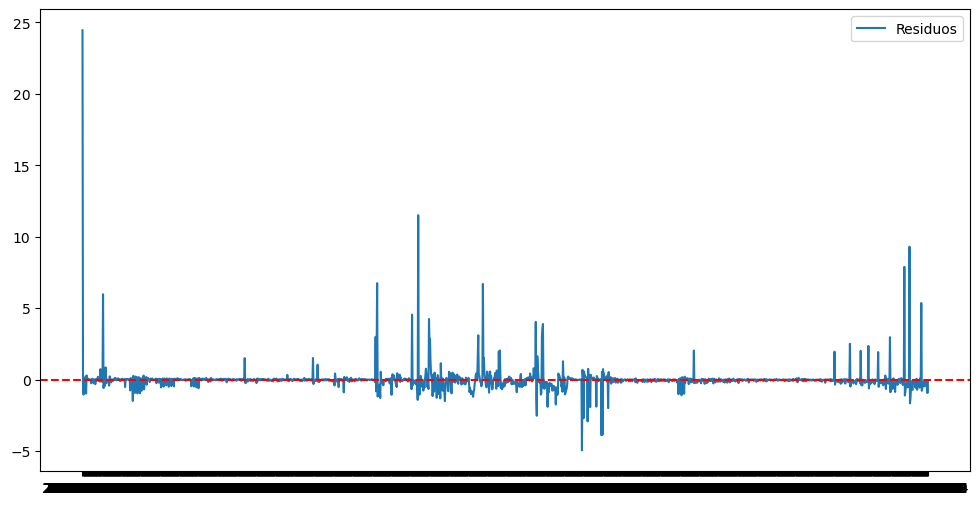

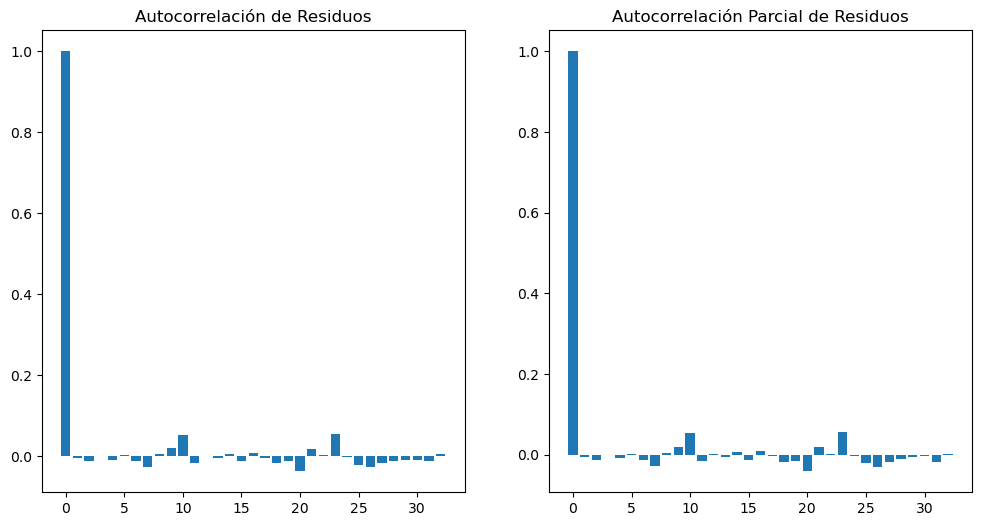

     lb_stat  lb_pvalue
10  7.108031   0.715208


In [133]:

from statsmodels.tsa.stattools import acf, pacf

# Obtener los residuos del modelo SARIMAX
residuos = resultado_sarimax.resid


plt.figure(figsize=(12, 6))
plt.plot(residuos, label='Residuos')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()


acf_residuos = acf(residuos, fft=False)
pacf_residuos = pacf(residuos)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.bar(range(len(acf_residuos)), acf_residuos)
plt.title('Autocorrelación de Residuos')
plt.subplot(122)
plt.bar(range(len(pacf_residuos)), pacf_residuos)
plt.title('Autocorrelación Parcial de Residuos')
plt.show()


ljung_box = sm.stats.acorr_ljungbox(residuos, lags=[10], return_df=True)
print(ljung_box)


Con un p-valor de 0.715208 no se rechaza la hipótesis nula entonces indicaria que los residuos del modelo no están autocorrelacionados.

Text(0, 0.5, 'P-valores ')

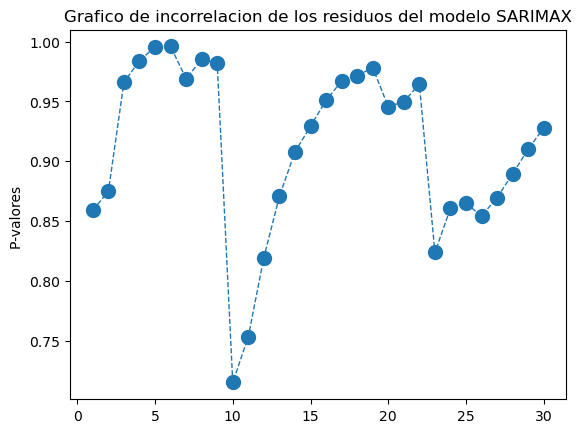

In [134]:
Incorr_residuos_modelo_ARMA=sm.stats.acorr_ljungbox(resultado_sarimax.resid, lags=30)
plt.plot(Incorr_residuos_modelo_ARMA.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo SARIMAX")
plt.ylabel("P-valores ")

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


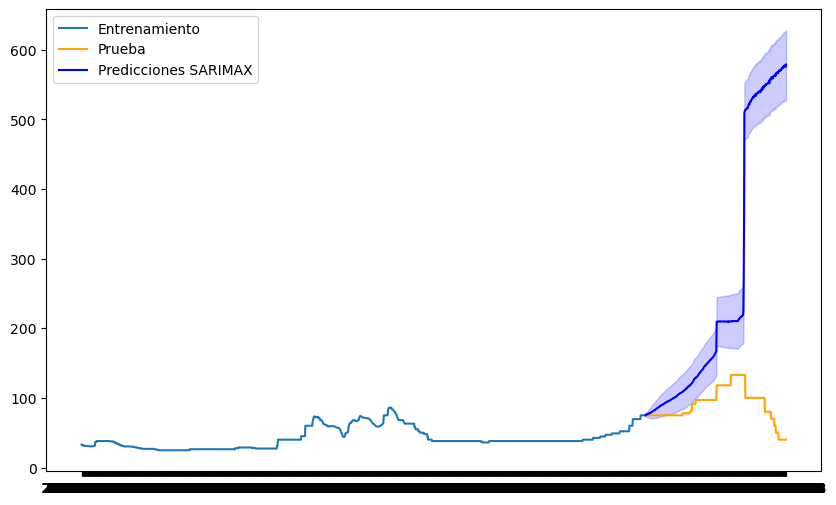

In [135]:
# Predicciones del modelo SARIMAX
pred_sarimax = resultado_sarimax.get_forecast(steps=len(test_aux), exog=test_aux[['Tipo_Cambio']])
pred_conf_int_sarimax = pred_sarimax.conf_int()


plt.figure(figsize=(10, 6))
plt.plot(train.index, train_aux['Tasa'], label='Entrenamiento')
plt.plot(test.index, test_aux['Tasa'], label='Prueba', color='orange')
plt.plot(test.index, pred_sarimax.predicted_mean, label='Predicciones SARIMAX', color='blue')
plt.fill_between(test.index, pred_conf_int_sarimax.iloc[:, 0], pred_conf_int_sarimax.iloc[:, 1], color='blue', alpha=0.2)
plt.legend()
plt.show()

In [137]:
# Métricas para el modelo SARIMAX
mse_sarimax = mean_squared_error(test['Tasa'], pred_sarimax.predicted_mean)
rmse_sarimax = np.sqrt(mse_sarimax)
mae_sarimax = mean_absolute_error(test['Tasa'], pred_sarimax.predicted_mean)
mape_sarimax = np.mean(np.abs((test['Tasa'] - pred_sarimax.predicted_mean) / test_aux['Tasa'])) * 100

print(f'Métricas SARIMAX:\nMSE: {mse_sarimax}\nRMSE: {rmse_sarimax}\nMAE: {mae_sarimax}\nMAPE: {mape_sarimax}')

Métricas SARIMAX:
MSE: 68201.80680855567
RMSE: 261.15475643486883
MAE: 172.16465888382987
MAPE: nan


Hasta ahora el modelo SARIMAX es el mejor.

# Serie 4: Préstamos

In [4]:
df = pd.read_excel("../dataset/prestamos/prestamos.xlsx")

df.head()

,fecha,cantidad
0,2018-01-02,22
1,2018-01-03,32
2,2018-01-04,38
3,2018-01-05,18
4,2018-01-08,26


In [5]:
# Convertir la columna 'date' a datetime
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d')

# Convertir a formato 'yyyy-mm-dd'
df['fecha'] = df['fecha'].dt.strftime('%Y-%m-%d')

In [6]:
df = df.set_index('fecha') 
df = df.sort_index()
df.head()

In [19]:
df.shape

(1609, 1)

In [20]:
df.describe()

,cantidad
count,1609.000000
mean,28.648229
std,96.200554
min,0.000000
25%,18.000000
50%,23.000000
75%,29.000000
max,2852.000000


In [ ]:
# Filtrar las fechas basadas en el año, extrayendo el año de la cadena de texto
pre_pandemia = df[df.index.str[:4].astype(int) < 2021]
pandemia = df[df.index.str[:4].astype(int) == 2021]
post_pandemia = df[df.index.str[:4].astype(int) > 2021]

In [21]:
post_pandemia.describe()

,cantidad
count,649.000000
mean,30.363636
std,17.798520
min,0.000000
25%,20.000000
50%,26.000000
75%,33.000000
max,107.000000


<h2>Ejercicio 1</h2>
Buscar 3 (tres) series de tiempo y exponer la problemática de interés analítico (es importante detallar cuáles fueron los motivos de elección y situar al lector en el contexto adecuado).

La serie de tiempo en cuestión fue elegida por necesidad de la empresa donde trabaja uno de los integrantes del grupo. Se trata de ciertos tipos de préstamos personales. El período de tiempo es desde el año 2018 a agosto de 2024. La granularidad es por día laboral, es decir, no se cuenta los fines de semana.

<h2>Ejercicio 2</h2>
Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias. 

Exponer los conceptos relacionados con la estacionariedad de la serie.

In [23]:
hist = px.histogram(df,  title=f"Histograma")
hist.show()

In [32]:
# Convertir el índice en una columna si aún no lo has hecho
df_copy = df.copy()
df_copy['fecha'] = df.index

# Extraer el año de la columna 'fecha'
df_copy['año'] = df_copy['fecha'].str[:4]  # Extraer el año de la fecha en formato 'yyyy-mm-dd'

# Crear el boxplot por año
fig = px.box(df_copy, x='año', y='cantidad', title='Boxplot de Cantidad por Año (Post Pandemia)', color='año')

# Mostrar el gráfico
fig.show()

In [11]:
# Crear un gráfico de serie de tiempo
fig = px.line(df, title='Serie de tiempo interactiva')

# Mostrar el gráfico interactivo
fig.show()

In [24]:
hist = px.histogram(post_pandemia,  title=f"Histograma")
hist.show()

In [34]:

# Convertir el índice en una columna si aún no lo has hecho
post_pandemia_copy = post_pandemia.copy()
post_pandemia_copy['fecha'] = post_pandemia.index

# Extraer el año de la columna 'fecha'
post_pandemia_copy['año'] = post_pandemia_copy['fecha'].str[:4]  # Extraer el año de la fecha en formato 'yyyy-mm-dd'

# Crear el boxplot por año
fig = px.box(post_pandemia_copy, x='año', y='cantidad', title='Boxplot de Cantidad por Año (Post Pandemia)', color='año')

# Mostrar el gráfico
fig.show()


In [16]:
# Crear un gráfico de serie de tiempo
fig = px.line(post_pandemia, title='Serie de tiempo interactiva')

# Mostrar el gráfico interactivo
fig.show()

Descomposición aditiva

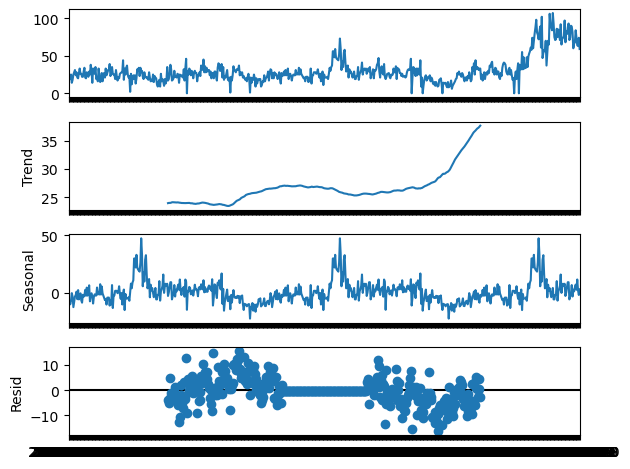

In [37]:
# Realizar la descomposición estacional aditiva
result = seasonal_decompose(post_pandemia, model='additive', period=252)

'''
"period=252" indica un ciclo completo anual basado en los días hábiles del mercado, que se usa con frecuencia en series temporales financieras.
'''

# Graficar los resultados
result.plot()
plt.show()

Descomposición multiplicativa

No se puede aplicar cuando hay ceros

<h2>Ejercicio 3</h2>
Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?. 

Justificar con teoría.

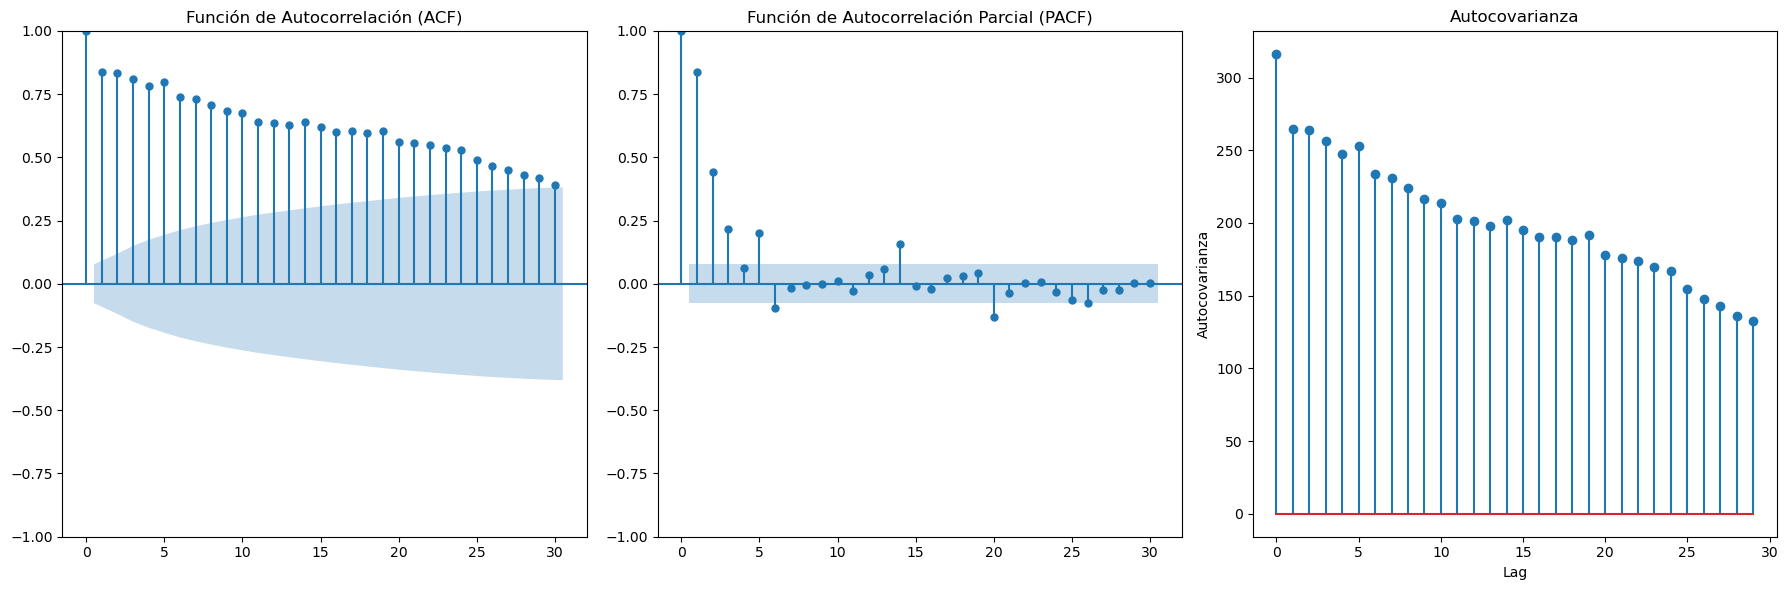

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Definir la serie de tiempo (columna cantidad)
Y = post_pandemia['cantidad']

# Crear el gráfico con subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Autocorrelación (ACF)
sm.graphics.tsa.plot_acf(Y, lags=30, ax=ax[0])
ax[0].set_title('Función de Autocorrelación (ACF)')

# Autocorrelación Parcial (PACF)
sm.graphics.tsa.plot_pacf(Y, lags=30, ax=ax[1])
ax[1].set_title('Función de Autocorrelación Parcial (PACF)')

# Función de autocovarianza personalizada
def autocovariance(series, lag):
    series_mean = np.mean(series)
    n = len(series)
    return np.sum((series[:n-lag] - series_mean) * (series[lag:] - series_mean)) / n

# Calcular la autocovarianza
lags = np.arange(30)
autocov = [autocovariance(Y.values, lag) for lag in lags]  # .values para usar los datos de la serie

# Gráfico de autocovarianza (sin el argumento use_line_collection)
ax[2].stem(lags, autocov)
ax[2].set_title('Autocovarianza')
ax[2].set_xlabel('Lag')
ax[2].set_ylabel('Autocovarianza')

# Mostrar el gráfico con layout ajustado
plt.tight_layout()
plt.show()




## Ejercicio 4
Realizar distintas pruebas de raíces unitarias para determinar si las series elegidas son o no estacionarias.

## Ejercicio 5

Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos SARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información/Selección y analizar significatividad individual y global de los parámetros del modelo).

## Ejercicio 6

Evaluar alguna métrica de performance teniendo en cuenta el entrenamiento del modelo entre Training Set y Testing Set.

## Ejercicio 7

Detallar una comparación con otros modelos estimados.


## Ejercicio 8

Efectuar un Análisis de Diagnóstico de las series temporales (Análisis sobre los Residuos del modelo, análisis gráfico de FAC, test de Ljung-Box, etc.).

## Ejercicio 9

Pronosticar con el modelo seleccionado para cada serie para una ventana temporal razonable, en función de la periodicidad y el comportamiento de las mismas.

##  Ejercicio 10
Construir un modelo de Vectores Autorregresivos (VAR) con las series elegidas para realizar predicciones sobre cada una de ellas.


## Ejercicio 11
Analizar la función impulso respuesta y realizar distintas pruebas para analizar la causalidad. 

Justificar la elección del modelo con todo lo visto en clase. Es posible complementar con otros análisis

## Ejercicio 12

En caso de presentar estacionalidad alguna de las series elegidas, se solicita determinar la representación más adecuada mediante algún modelo SARIMA y comparar los resultados con los modelos determinados en el trabajo anterior. 

(Opcional) Realizar la prueba de hipótesis de HEGY para testear la conjetura de raíz unitaria sobre las series elegidas.
